In [2]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_features = pd.read_csv('train_features.csv')
train_targets_nonscored = pd.read_csv('train_targets_nonscored.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')

# Overview info from Kaggle:

In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

### Two notes:

the training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
the re-run dataset has approximately 4x the number of examples seen in the Public test.

### Files:
train_features.csv - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. 

cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

train_targets_scored.csv - The binary MoA targets that are scored.

train_targets_nonscored.csv - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.

test_features.csv - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

sample_submission.csv - A submission file in the correct format.

# sig_id

sig_id is unique identifier for treatment compounds / control vehicles, 23,814 in total

In [4]:
len(train_features['sig_id'].unique())

23814

# Train Features:

In [5]:
train_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


## Categorical

cp_type tells whether a compound was treated with a compound (trt_cp) or a control perterbation (ctl_vehicle)

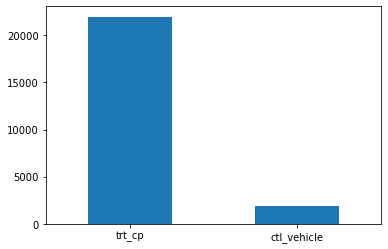

In [5]:
#value counts of cp_type
train_features['cp_type'].value_counts().plot.bar(rot=0)

cp_time indicates the duration of the treatment in hours

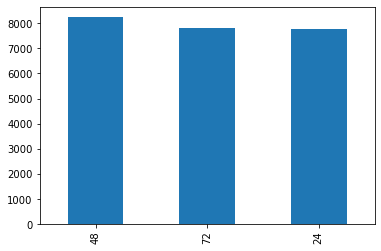

In [6]:
train_features['cp_time'].value_counts().plot.bar()

cp_dose indicates whether it was a high or low dose of the compound (or control)... which is which?

Discussion post on Kaggle:

"I checked number of positive target per data of each labels under same cp_time.
The results are,

D1 vs D2 (positive targets/data)

24h 0.7086 : 0.7053
48h 0.7055 : 0.7076
72h 0.7102 : 0.7065

except for 48h condition, D1 gives slightly more MoAs on average.
So, I now suppose D1 is high and D2 is low…"

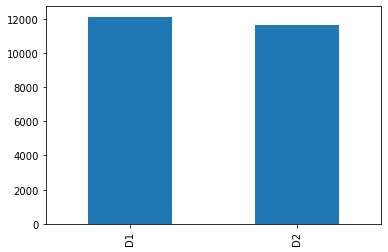

In [7]:
train_features['cp_dose'].value_counts().plot.bar()

## Continuous

features labelled 'g-#' are gene expression data - 771 genes in question for 23813 samples. Gene expression measured with L1000 assay. L1000 assay measures presence of mRNA as a result of transcription of genes in question.

In [8]:
print(f'gene expression data ranges from {train_features.filter(regex=("g-.*")).values.min()} to {train_features.filter(regex=("g-.*")).values.max()}')

gene expression data ranges from -10.0 to 10.0


In [9]:
train_features.filter(regex=("g-.*")).head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


features labelled 'c-#' are cellular viability data - 100 cell types in question for 23813 samples. Cell viability measured with PRISM dna barcoding

In [10]:
print(f'cellular viability data ranges from {train_features.filter(regex=("c-.*")).values.min()} to {train_features.filter(regex=("c-.*")).values.max()}')

cellular viability data ranges from -10.0 to 6.412


In [11]:
train_features.filter(regex=("c-.*")).head()

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,-0.0600,0.1083,0.6864,0.4043,0.4213,-0.6797,0.2888,0.4323,-0.3381,0.3407,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0.0927,0.2723,0.2772,0.7776,0.3679,0.5696,0.2835,1.4080,0.3745,0.6775,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,-0.1312,-1.4640,0.3394,-1.7790,0.2188,0.5826,-0.7513,0.0543,0.7182,-0.4159,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,-0.3998,-4.5520,-2.7350,-1.9630,-2.8610,-1.2670,-2.5830,-0.5036,-3.1590,-1.8510,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,-0.3774,0.7364,-0.1659,0.2341,1.0060,0.3204,-0.0852,-0.2284,-0.2533,-0.3174,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


## Train feature correlation:

In [12]:
feature_1 = []
feature_2 = []
correlation = []
for col1 in tqdm(train_features.columns[4:]):
    for col2 in train_features.columns[4:]:
        if col1 != col2:
            if abs(train_features[col1].corr(train_features[col2])) > 0.3:
                feature_1.append(col1)
                feature_2.append(col2)
                correlation.append(abs(train_features[col1].corr(train_features[col2])))

100%|████████████████████████████████████████████████████████████████████████████████| 872/872 [03:17<00:00,  4.42it/s]


In [13]:
corr_df = pd.DataFrame(list(zip(feature_1, feature_2, correlation)), columns =['feature1', 'feature2','correlation']) 
corr_df['abs_correlation'] = abs(corr_df['correlation'])
corr_df = corr_df.sort_values(by='abs_correlation', ascending=False)
corr_df.drop('abs_correlation',axis=1,inplace=True)
corr_df = corr_df.reset_index()

In [19]:
corr_df

,index,feature1,feature2,correlation
0,196542,c-52,c-42,0.924619
1,191126,c-42,c-52,0.924619
2,207876,c-73,c-13,0.923344
3,175538,c-13,c-73,0.923344
4,182446,c-26,c-13,0.921875
...,...,...,...,...
221933,119808,g-533,g-761,0.300004
221934,155298,g-711,g-8,0.300004
221935,1513,g-8,g-711,0.300004
221936,200742,c-60,g-653,0.300003


# Train Targets:

train targets is a binary encoded classfication of each compound in question. 

train_targets_scored are compounds that will be used for scoring in the competition

train_targets_nonscored are optional fully annotated compounds included in the dataset to potentially be used for training, but not included in the competition scoring.

**note: many compounds have 0 MoA classifications while others have as many as 7 classifications. More on this later.

In [15]:
drop = 'sig_id'
print(f'{len(list(train_targets_scored.drop(drop,axis=1).columns))} total scored compound MoA classificaitons')
print(f'{len(list(train_targets_nonscored.drop(drop,axis=1).columns))} total nonscored compound MoA classificaitons')
print('\n')
print(f'Scored classification list: \n {list(train_targets_scored.drop(drop,axis=1).columns)}')

206 total scored compound MoA classificaitons
402 total nonscored compound MoA classificaitons


Scored classification list: 
 ['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor', 'acat_inhibitor', 'acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor', 'adenosine_receptor_agonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist', 'adrenergic_receptor_antagonist', 'akt_inhibitor', 'aldehyde_dehydrogenase_inhibitor', 'alk_inhibitor', 'ampk_activator', 'analgesic', 'androgen_receptor_agonist', 'androgen_receptor_antagonist', 'anesthetic_-_local', 'angiogenesis_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'antibiotic', 'anticonvulsant', 'antifungal', 'antihistamine', 'antimalarial', 'antioxidant', 'antiprotozoal', 'antiviral', 'apoptosis_stimulant', 'aromatase_inhibitor', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synth

In [16]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Number of MoA Classifications per compound overview

Most compounds have 1 MoA classification (> 12000), many have 0 (> 8000), some have 2 or 3 (~2000). Overall range 0-7.

100%|████████████████████████████████████████████████████████████████████████████| 23814/23814 [26:28<00:00, 14.99it/s]


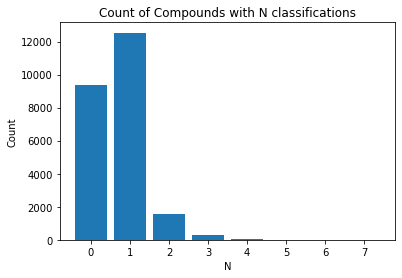

In [17]:
classification_counts = []
for i in tqdm(range(len(train_targets_scored))):
    classification_counts.append(sum(train_targets_scored.drop(drop,axis=1).iloc[i]))
    
counts = {}
for i in np.arange(0,8,1):
    counts[i] = 0
for item in classification_counts:
    counts[item] = counts[item] + 1

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.ylabel('Count')
plt.xlabel('N')
plt.title('Count of Compounds with N classifications')
plt.show()

# Counts per MoA classification for most common MoA's

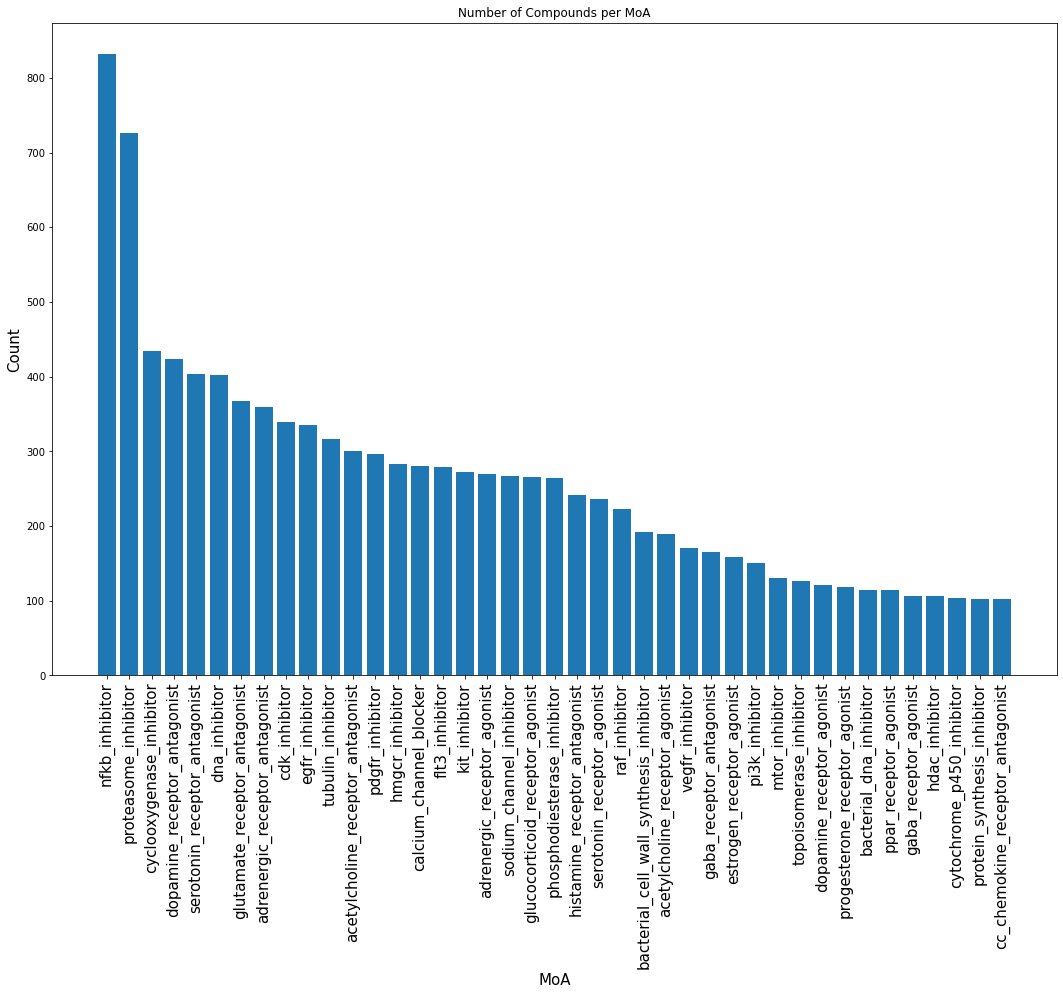

In [18]:
class_counts = {}
for col in train_targets_scored.columns[1:]:
    if sum(train_targets_scored[col]) > 100:
        class_counts[col] = sum(train_targets_scored[col])
class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}

fig = plt.figure(figsize=(18,12))
plt.bar(range(len(class_counts)), list(class_counts.values()), align='center')
plt.xticks(range(len(class_counts)), list(class_counts.keys()), fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('MoA', fontsize=15)
plt.xticks(rotation=90)
plt.title('Number of Compounds per MoA')
plt.show()